<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/09_milestone_project_2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NL P model to to make reading medical abstracts easier.
The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here:
https://arxiv.org/abs/1612.05251

**Resources** If you want to find the ground truth for this notebook(with lots of diagrams and text annotations) see the GitHub :
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to GPU


In [73]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-abc9aab0-524f-ac57-e636-45003b61771f)


## Get data
Since we'll be replicating the paper above(PubMed 200K RCT), let's download the dataset they use.
We can do so from the authors GitHub :
https://github.com/Franck-Dernoncourt/pubmed-rct


In [74]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [75]:
# Check what files are in the PubMed_20K dataset
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
#! ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [76]:
# Start our experiments using the 20K dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [77]:
# Check all of the filenames in the target directory 
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.
And one of the best ways to become one with the data is to....

> Visualize, Visualize, Visualize

So with that in mind, let's write a function to read all the lines of a target text file.

In [78]:
# Create function to read the lines of a document

def get_lines(filename) :
  """
  Reads filename(a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath.

  Returns :
  A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f :
    return f.readlines()


In [79]:
# Let's read in the training lines
train_lines = get_lines(data_dir  + "train.txt")
train_lines[:28]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [80]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented ...

```
[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines' : 11},
   ...]   
```

Let's write a function which turns each of our datasets into the above format, so we can continue to prepare our data for modelling.


In [81]:
def preprocess_text_with_line_numbers(filename) :
  """
  Returns list of dictionary of abstract line data.

  Takes in filename, reads it contents and sort through each line, 
  extracting things like the target label, text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target line
  for line in input_lines :

    if line.startswith("###") : # check to see if the line is an ID line
      abstract_id = line
      abstract_lines= "" # reset the abstract string if the line is an ID line

    elif line.isspace() : # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract lines into separate lines     
      # Iterate through each line in a single abstract and count at same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split) :
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data ={} # create an empty dictionar for each line
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear on the abstract
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the target abstract? (start from 0) 
        abstract_samples.append(line_data) # add line data to abstract samples list

    else : # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples



In [82]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for val
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 501 ms, sys: 87.3 ms, total: 589 ms
Wall time: 595 ms


In [83]:
# Check the first abstract of our training  data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it

In [84]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [85]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

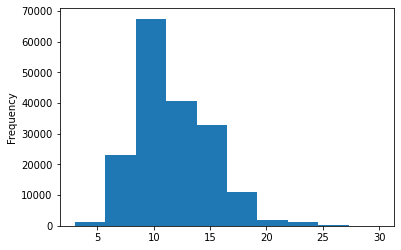

In [86]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [87]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [88]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML model requires numeric labels)

In [89]:
# One hot encode labels
# Sparse Matrix not applicable here , read more https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [90]:
## Label encode labels
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [91]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting  a series of modelling experiments...
As usual, we're going to be trying out a bunch of different models and seeing which one works best.
And as always, we're going to start with a baseline model (TF-IDF Multinomial Naive Bayes classifier).

Refer to the blog here for understanding ML concepts
https://chrisalbon.com/


## Model 0 : Getting a baseline model

We will learn machine learning experiments, we'll use SkLearn's Multinomial Naive Bayes using TF-IDF formula to convert words to numbers.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()), # Convert words to numbers using tdidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences, 
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [93]:
# EValuate baseline mdoel on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [94]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
In the previous modules, we wrote a function to compare predictions across different metrics(accuracy, precision, recall and f1)
and rather than rewriting it here, let's download from our helper function script : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [95]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-14 17:32:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-14 17:32:33 (79.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [96]:
from helper_functions import calculate_results

In [97]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we'got to create vectorization and embedding layers.

In [98]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [99]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [100]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

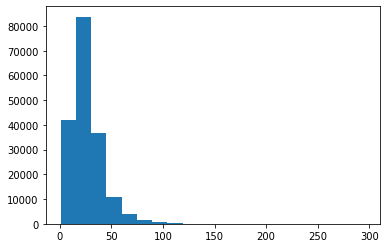

In [101]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [102]:
# What percentile covers 95% of the sentence length
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [103]:
# Max sequence length in the training set
max(sent_lens)

296

### Create the TextVectorizer (tokenization)

We want to make a layer which maps our texts from words into numbers

In [104]:
# How many words are in our voab? (taken from table 2 in https://arxiv.org/pdf/1710.06071.pdf )
max_tokens = 68000

In [105]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Link to TextVectorization : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len, # desired output length of vectorized sequence
                                    standardize="lower_and_strip_punctuation", # default value
                                    split="whitespace", # default value
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # default  value                               
                                    pad_to_max_tokens = True) # default value
                                    

In [106]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [107]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
blood pressure and heart rate were documented every @ minutes .

Length of text: 11

Vectorized text:[[ 107  200    3  260   78    9 1899  418  340    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [108]:
# How many words in our training vocabulary ?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab : {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab :v{rct_20k_text_vocab[-5:]}")

Number of words in vocab : 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab :v['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [109]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

### Create custom text embedding

In [110]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                             output_dim = 128, # Note: different embedding sizes result in drastically differnt number of params to train
                             mask_zero=True, # use masking to handle  variable sequence lengths(save space)
                             name="token_embedding")
token_embed

In [111]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization(before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 blood pressure and heart rate were documented every @ minutes .

Sentence after vectorization(before embedding):
 [[ 107  200    3  260   78    9 1899  418  340    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.02783183 -0.01470805 -0.0271597  ... -0.0307879   0.0025808
   -0.01623756]
  [ 0.04646349 -0.00568985  0.0380892  ... -0.00522733 -0.04895559
   -0.03798204]
  [ 0.04376078  0.04253007 -0.04114183 ...  0.03443455 -0.04758523
   -0.03256788]
  ...
  [-0.04185325 -0.01195786  0.01091157 ... -0.00829224 -0.01563445
    0.04604776]
  [-0.04185325 -0.01195786  0.01091157 ... -0.00829224 -0.01563445
    0.04604776]
  [-0.04185325 -0.01195786  0.01091157 ... -0.00829224 -0.01563445
    0.04604776]]]

Embedded sentence shape: (1, 55, 12

## Creating datasets(making sure our data loads as fast as possible)
We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps are discussed at length in these 2 resources :

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [112]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [113]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [114]:
# Take the TensorSliceDataset's and turn them into prefetch dataset
# https://www.tensorflow.org/guide/data_performance#prefetching
# tf.data.AUTOTUNE - automatically prefetch as many samples as you can
# Dont run it more than once
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D with token embeddings

In [115]:
# Create 1D conv model to process sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)  # create embeddings
x = layers.Conv1D(filters = 64, # number of hidden units
                  kernel_size = 5, # take 5 words at a time n-gram = 5
                  strides=1, # default value
                  padding="same", # default value
                  activation="relu" 
                  )(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


In [116]:
# Compile model 1
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [117]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
_________________________________________________

In [118]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "milestone_project_experiments"

In [119]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [120]:
len(train_dataset)  * 32 #(batch size)

180064

In [121]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)), # only train on 10% of the total training batchs
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps =int(0.1 * len(valid_dataset))) # only validate on 10% of the batches


Epoch 1/3
562/562 [==============================] - 79s 85ms/step - loss: 0.9220 - accuracy: 0.6352 - val_loss: 0.6850 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 47s 83ms/step - loss: 0.6605 - accuracy: 0.7553 - val_loss: 0.6363 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 48s 85ms/step - loss: 0.6184 - accuracy: 0.7751 - val_loss: 0.5970 - val_accuracy: 0.7842


In [122]:
# Evaluate on whole dataset
results_model_1 = model_1.evaluate(valid_dataset)
results_model_1

945/945 [==============================] - 3s 4ms/step - loss: 0.5991 - accuracy: 0.7870


[0.5990913510322571, 0.787038266658783]

In [123]:
# Make predictions (our model predicts predictions probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.4372252e-01, 1.5892896e-01, 7.9995275e-02, 2.7878937e-01,
         3.8563874e-02],
        [3.8518855e-01, 3.4493861e-01, 1.1727505e-02, 2.4903402e-01,
         9.1113755e-03],
        [1.7256926e-01, 1.0288682e-02, 2.6243946e-03, 8.1447524e-01,
         4.2434480e-05],
        ...,
        [8.0350947e-06, 6.6672202e-04, 9.2672941e-04, 3.5573189e-06,
         9.9839491e-01],
        [6.7829624e-02, 5.0610596e-01, 7.7870131e-02, 8.1278957e-02,
         2.6691538e-01],
        [1.6227998e-01, 6.5435296e-01, 5.3023219e-02, 6.5583922e-02,
         6.4759910e-02]], dtype=float32), (30212, 5))

In [124]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [125]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [126]:
# Calculate model_1_results = 
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.70382629418773,
 'f1': 0.7846587242159004,
 'precision': 0.7841551868467432,
 'recall': 0.7870382629418774}

In [127]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with later created USE pretrained embeddings.

More pretrained training models for all domains here 
https://huggingface.co/

In [128]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [129]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence :\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence :
 subjects were randomized into @ groups ( n = @ ) to evaluate superiority to placebo ( visits @ to @ ) and @ groups ( n = @ ) to evaluate noninferiority to olopatadine ( visit @ ) .
Sentence after embedding:
[ 0.02499036 -0.06802253 -0.01146875 -0.06458484 -0.04471185  0.02743505
 -0.01264824 -0.07530107 -0.07338442  0.05170598  0.07000187  0.05250169
  0.06624097  0.02772662 -0.0639934  -0.06871744 -0.04610502 -0.00251478
  0.00559184 -0.04394891  0.07980164  0.07690874 -0.07877067  0.03454126
  0.00038298  0.0566417  -0.06255049 -0.01961011  0.05315802 -0.06381531]

Length of sentence embedding: 512


In [130]:
use_embedded_sentence.shape

TensorShape([1, 512])

### Building and fitting an NLP extraction mdoel using pretrained embeddings from Tensorflow Hub

In [131]:
# Define feature extraction model using TF Hub layer
from tensorflow.keras import layers

inputs = layers.Input(shape=[], dtype="string") # required empty list for pretrained layer
pretrained_embedding  = tf_hub_embedding_layer(inputs) # tokenize and embeddings of each sequence(512 long vectors)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note : you could add more layes here if you wanted to 
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [132]:
# Model summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [133]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9158 - accuracy: 0.6479 - val_loss: 0.7959 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7676 - accuracy: 0.7014 - val_loss: 0.7553 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7512 - accuracy: 0.7134 - val_loss: 0.7388 - val_accuracy: 0.7104


In [134]:
# Evaluate the model
results_model_2 = model_2.evaluate(valid_dataset)
results_model_2

945/945 [==============================] - 10s 10ms/step - loss: 0.7401 - accuracy: 0.7143


[0.7400808334350586, 0.7142525911331177]

In [135]:
# Make predictions with feature extraction mdoel
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

array([[4.11515146e-01, 3.69059026e-01, 2.11920985e-03, 2.09327921e-01,
        7.97872711e-03],
       [3.34544122e-01, 5.09054065e-01, 4.01086686e-03, 1.48819163e-01,
        3.57182557e-03],
       [2.30362669e-01, 1.66247651e-01, 1.84638835e-02, 5.48509657e-01,
        3.64160724e-02],
       [1.35076009e-02, 4.40119356e-02, 8.19415331e-01, 7.69838458e-03,
        1.15366735e-01],
       [3.06004714e-02, 2.17922002e-01, 2.35681206e-01, 1.28830774e-02,
        5.02913237e-01],
       [9.96426563e-04, 2.33958033e-03, 6.90319479e-01, 1.41723925e-04,
        3.06202888e-01],
       [1.97679736e-03, 3.32751335e-03, 6.31452918e-01, 1.26601139e-03,
        3.61976832e-01],
       [4.06833366e-03, 2.69407947e-02, 4.98565793e-01, 1.29875401e-03,
        4.69126314e-01],
       [7.10212742e-04, 6.71348721e-03, 2.03201249e-02, 1.25431397e-03,
        9.71001804e-01],
       [1.37054190e-01, 6.93545640e-01, 2.58994028e-02, 8.17476660e-02,
        6.17530905e-02]], dtype=float32)

In [136]:
# Convert the predictions probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [137]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)


In [138]:
model_2_results

{'accuracy': 71.42195154243348,
 'f1': 0.7111586095231073,
 'precision': 0.7144110898066165,
 'recall': 0.7142195154243347}

In [139]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}


## Model 3 : Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.
Previously, we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.


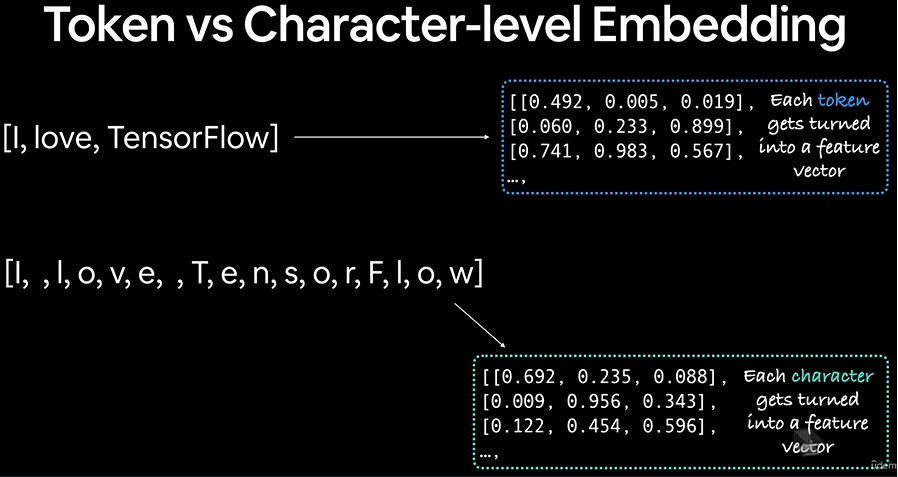

### Creating a character-level tokenizer

In [140]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [141]:
# Make function to split sentences into characters
def split_chars(text) :
  return " ".join(list(text))


# Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

's u b j e c t s   w e r e   r a n d o m i z e d   i n t o   @   g r o u p s   (   n   =   @   )   t o   e v a l u a t e   s u p e r i o r i t y   t o   p l a c e b o   (   v i s i t s   @   t o   @   )   a n d   @   g r o u p s   (   n   =   @   )   t o   e v a l u a t e   n o n i n f e r i o r i t y   t o   o l o p a t a d i n e   (   v i s i t   @   )   .'

In [142]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [143]:
# What's average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

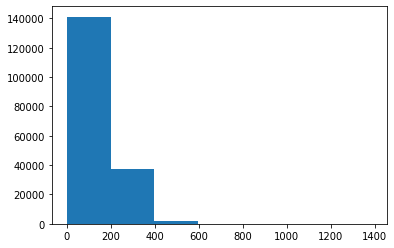

In [144]:
# Check the distribution of our sequence at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [145]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

> Note: Max token for a character level vectorization is how many different characters is used in your dataset. 
Which is generally ur alphanumeric characters

In [146]:
# Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [147]:
# Create char-level token vectorizer instance
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV tone (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,                                    
                                    output_mode="int",
                                    output_sequence_length = output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if uou want to get punctuations in
                                    name="char_vectorizer")

In [148]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [149]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Numer of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Numer of different characters in character vocab: 28
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [150]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n {random_train_chars}")
print(f"\nLength of random_train chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars :\n {vectorized_chars}")
print(f"\nLength of vectorized chars : {len(vectorized_chars[0])}")

Charified text : 
 t h e   i n t e r v e n t i o n   w a s   a d m i n i s t e r e d   f o r   @ w e e k s   .

Length of random_train chars: 40

Vectorized chars :
 [[ 3 13  2  4  6  3  2  8 21  2  6  3  4  7  6 20  5  9  5 10 15  4  6  4
   9  3  2  8  2 10 17  7  8 20  2  2 23  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

### Creating a character-level embedding

In [179]:
# Create char embedding layer
from tensorflow.keras import layers

char_embed = layers.Embedding(input_dim = len(char_vocab), #number of different characters
                                  output_dim = 25, # this is the size of the char embedding in the paper.  https://arxiv.org/pdf/1612.05251.pdf
                                  mask_zero=True,
                                  name = "char_embed")

In [180]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text:
 t h e   i n t e r v e n t i o n   w a s   a d m i n i s t e r e d   f o r   @ w e e k s   .

Embedded chars. (after vectorization and embedding):
[[[-0.02610075 -0.01859367  0.00389814 ... -0.04879228 -0.04128861
    0.00506892]
  [-0.00923496 -0.0316779  -0.03528572 ...  0.0228057   0.02562729
    0.03101948]
  [ 0.01789792 -0.04392526  0.04309919 ...  0.00375453 -0.04830233
   -0.02299598]
  ...
  [ 0.00965852  0.02220419  0.01144873 ... -0.0173154   0.03608027
    0.02906943]
  [ 0.00965852  0.02220419  0.01144873 ... -0.0173154   0.03608027
    0.02906943]
  [ 0.00965852  0.02220419  0.01144873 ... -0.0173154   0.03608027
    0.02906943]]]

Character embedding shape:(1, 290, 25)


### Building a Conv1D model to fit on the character embeddings


In [181]:
from tensorflow.keras import layers

# Make Conv1D on chars only
inputs = layers.Input(shape=(1, ), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters = 64,                  
                  kernel_size=5,
                  padding="same",
                  activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs= inputs, 
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [182]:
# Get model 3 summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [183]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset =   tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset =  tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [184]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3, 
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2571 - accuracy: 0.4873 - val_loss: 1.0586 - val_accuracy: 0.5781
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0198 - accuracy: 0.5944 - val_loss: 0.9534 - val_accuracy: 0.6263
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9414 - accuracy: 0.6325 - val_loss: 0.8836 - val_accuracy: 0.6619


In [185]:
# Evaluate the model 3
model_3_results = model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9025 - accuracy: 0.6530


In [186]:
# Check model 3 prediction probabilities
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.11119837, 0.2886006 , 0.17747605, 0.35972735, 0.0629976 ],
       [0.12954584, 0.47030666, 0.07142752, 0.04288761, 0.28583232],
       [0.10587165, 0.19348043, 0.34043348, 0.16448091, 0.1957335 ],
       ...,
       [0.01080021, 0.04633739, 0.10323143, 0.03500132, 0.8046296 ],
       [0.01245307, 0.07097237, 0.14273478, 0.02081442, 0.7530254 ],
       [0.44827577, 0.35905477, 0.08789165, 0.08998884, 0.01478901]],
      dtype=float32)

In [187]:
# Turn prediction probabilites to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 4, 0])>

In [188]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.29524692175295,
 'f1': 0.6436172516545147,
 'precision': 0.6451737125110378,
 'recall': 0.6529524692175295}

In [189]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4 : Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate(`layers.Concatenate`)
4. Build a seris of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [190]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Create a character-level model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
# hidden units of BiDirectional doubles, so 25 becomes 50, but we will use 24 (multiples of 8)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenatate token and char inputs(create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layer - adding in Dropout, discussed in section 4.2 of the paper.
combined_dropout = layers.Dropout(0.5)(token_char_concat) # randomly set input units to 0 with a rate , here it is 50%
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")






In [191]:
# Get a summary for our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

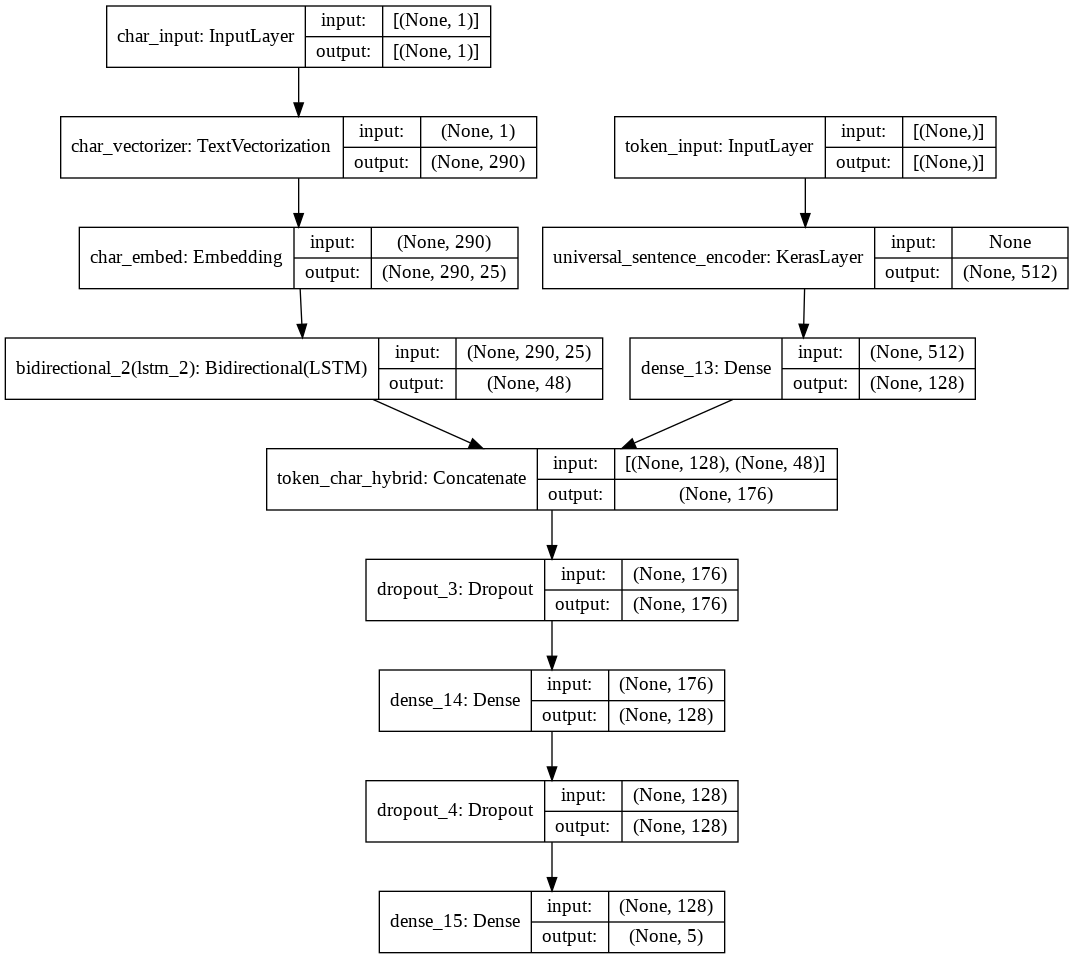

In [192]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

> Note : For understanding a better use of multi-modal, refer to the AirBnB multi-modal reference here
https://medium.com/airbnb-engineering/widetext-a-multimodal-deep-learning-framework-31ce2565880c

In [193]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you may want to try it
                metrics=["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [194]:
# Combine chars and tokens into a dataset
# Order of tuples here should match the order of inputs to the model inputs we passed above (model_4)
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [195]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [196]:
# Check up our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [197]:
# Fit the combined model_4

history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3, 
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))



Epoch 1/3
562/562 [==============================] - 37s 51ms/step - loss: 0.9907 - accuracy: 0.6074 - val_loss: 0.7766 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7992 - accuracy: 0.6922 - val_loss: 0.7161 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7734 - accuracy: 0.7071 - val_loss: 0.6864 - val_accuracy: 0.7384


In [198]:
# Evaluate our model 4

model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6907 - accuracy: 0.7363


[0.6907264590263367, 0.7362637519836426]

In [199]:
# Make prediction probabilities for token-character model hybrid 4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.9443430e-01, 3.8643530e-01, 4.9036066e-03, 2.0534329e-01,
        8.8834642e-03],
       [3.3641502e-01, 4.6715313e-01, 4.6351459e-03, 1.8906963e-01,
        2.7270610e-03],
       [3.0966377e-01, 1.3268141e-01, 3.0406376e-02, 5.0144899e-01,
        2.5799418e-02],
       ...,
       [5.2470074e-04, 8.9422194e-03, 5.8520902e-02, 3.1816636e-04,
        9.3169403e-01],
       [4.7014551e-03, 5.3454578e-02, 1.8382084e-01, 2.4707953e-03,
        7.5555229e-01],
       [1.9589069e-01, 3.6032775e-01, 3.2421541e-01, 1.9882333e-02,
        9.9683784e-02]], dtype=float32)

In [200]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [201]:
# Calculate model_4 performance (token-char hybrid model)
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.62637362637363,
 'f1': 0.732468870964755,
 'precision': 0.7351750853279722,
 'recall': 0.7362637362637363}

In [202]:
model_1_results

{'accuracy': 78.70382629418773,
 'f1': 0.7846587242159004,
 'precision': 0.7841551868467432,
 'recall': 0.7870382629418774}

## Feature Engineering

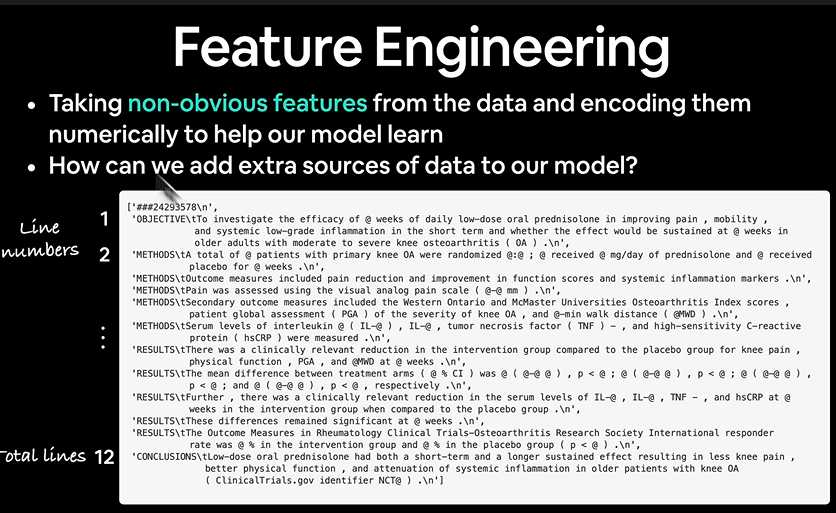

## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [203]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note** : Any engineered feature used to train a model need to be available at the run time.
In our case, line numbers and total lines are available

### Create positional embeddings


In [204]:
# How many different line numbers are there

train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

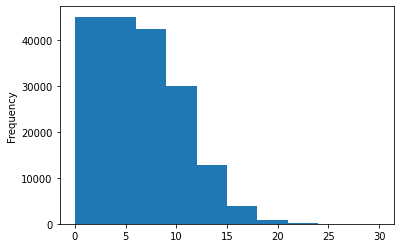

In [205]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [206]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot =tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's one-hot encode the total lines feature...

In [207]:
# How many "total_lines" are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

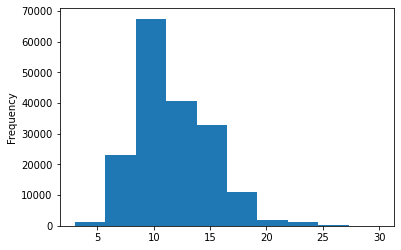

In [208]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [209]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [210]:
# Use TensorFlow to one-hot encode "total_lines" column
train_total_lines_one_hot  = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot  = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot  = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:15], train_total_lines_one_hot.shape


(<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

###  Building a tribrid embedding model

1. Create a token-level model
2. Create a char-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combined the outputs of 1 & 2 using `tf.keras.layers.Concatentate`
6. Combine the outputs of 3, 4 , 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1 , 2 , 3, 4 and outputs of 7 into a `tf.keras.Model`


In [211]:
#1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, 
                             outputs = token_outputs)

# 2. Char level model
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, 
                           outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, 
                                   outputs = x)

#4. Total Lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

#5. Combine token and char embeddings into a hybrid embedding 1 & 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, 
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)


# 6. Combined positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input, 
                                   total_lines_model.input, 
                                   token_model.input, 
                                   char_model.input], 
                         outputs =output_layer,
                         name="model_5_tribrid_embedding_model")


In [212]:
# Get a sumamary for our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

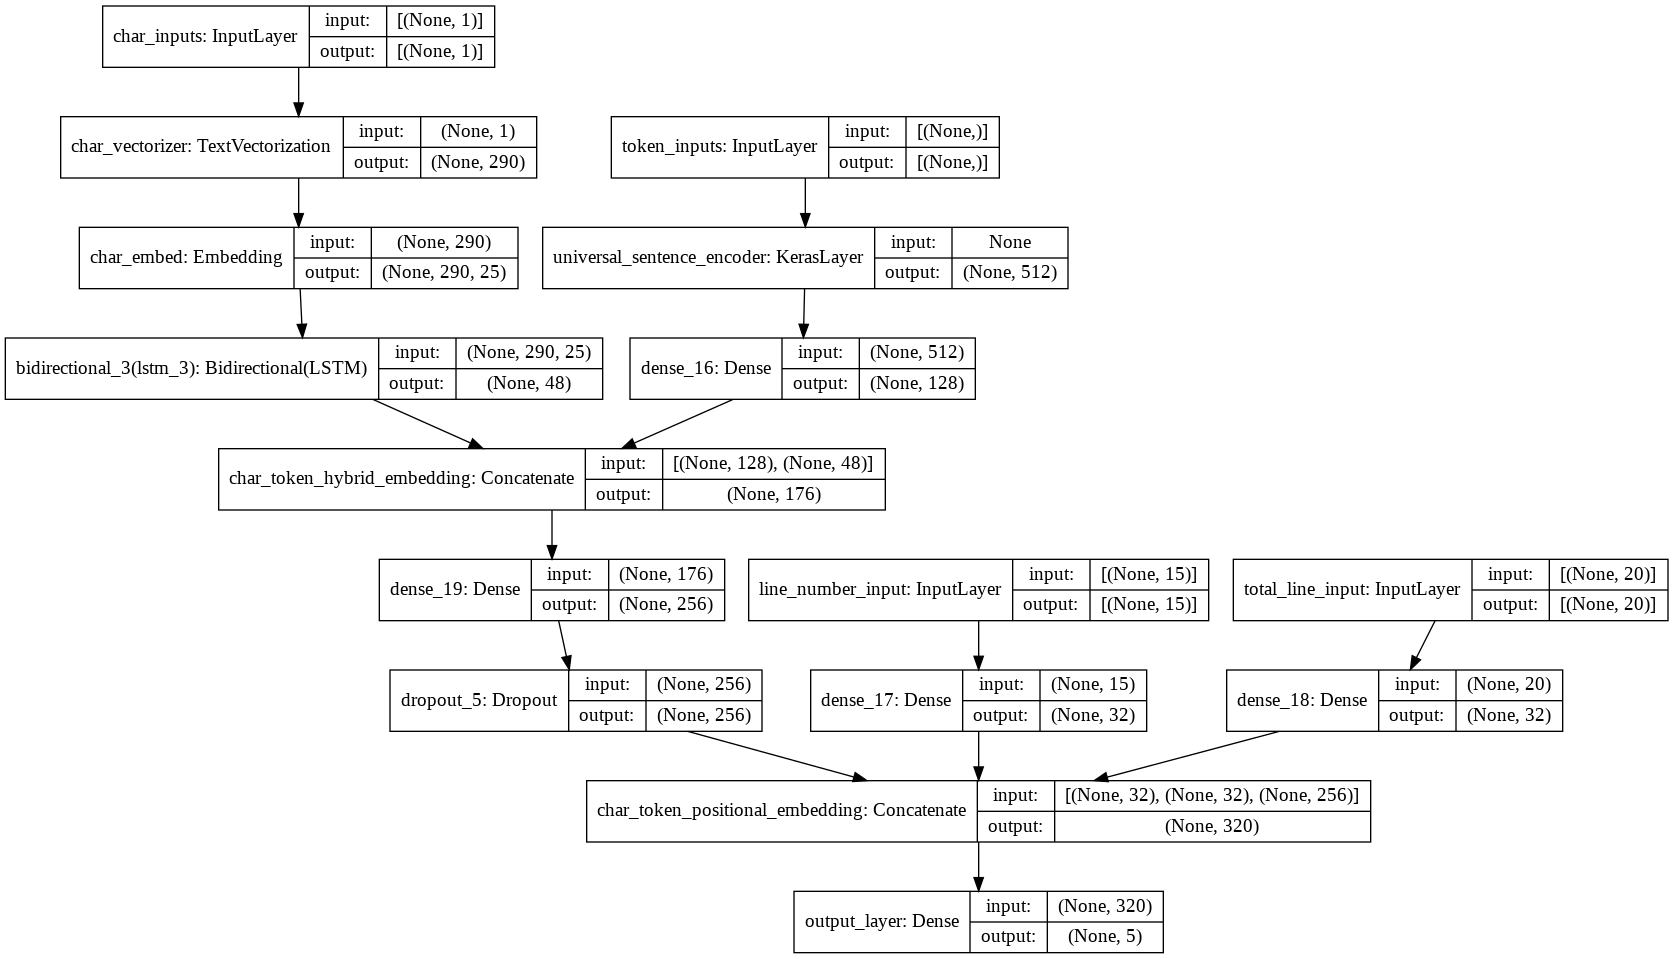

In [215]:
# Plot model 5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing ?

For example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and  not consider other classes...

Really confident : `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization : `[0.01, 0.01, 0.96, 0.01, 0.01]`  

If label_smoothing is 0.2 ( it adds 0.2 / num_classes for other non-target labels)

> **Resources:**  for more on label smoothing, see this blog post from PyImageSearch : https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/


In [216]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Create tribrid embedding datasets using tf.data

In [224]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                 train_total_lines_one_hot, 
                                                                 train_sentences, 
                                                                 train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)# make train labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, 
                                                    train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)# make train labels
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, 
                                                  val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [225]:
# Check input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [226]:
len(train_char_token_pos_dataset), len(val_char_token_pos_dataset)

(5627, 945)

In [227]:
### Fitting, evaluating and making predictions with our tribrid model

history_model_5 = model_5.fit(train_char_token_pos_dataset, 
                              epochs=3, 
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 36s 52ms/step - loss: 1.1003 - accuracy: 0.7204 - val_loss: 0.9791 - val_accuracy: 0.8115
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9668 - accuracy: 0.8169 - val_loss: 0.9499 - val_accuracy: 0.8235
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9502 - accuracy: 0.8236 - val_loss: 0.9384 - val_accuracy: 0.8291


In [230]:
# Make prediction probablities

model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

array([[0.49440733, 0.10503859, 0.01022063, 0.37439698, 0.01593648],
       [0.57329863, 0.10411488, 0.03837654, 0.2780033 , 0.00620663],
       [0.26591134, 0.10874117, 0.10750038, 0.45516863, 0.06267847],
       ...,
       [0.04237326, 0.0954745 , 0.04226072, 0.03355821, 0.7863333 ],
       [0.03028538, 0.26828235, 0.06872488, 0.02699731, 0.60571015],
       [0.20043729, 0.55992776, 0.12855582, 0.0415173 , 0.06956194]],
      dtype=float32)

In [231]:
# Turn prediciton probabilities into pred

model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [233]:
# Calculate model 5 results
model_5_results = calculate_results(y_true = val_labels_encoded, 
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.38739573679332,
 'f1': 0.8328280846183697,
 'precision': 0.8326422542471428,
 'recall': 0.8338739573679332}

## Compare model results

In [242]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding" : model_1_results,
                                  "model_2_pretrained_token_embedding" : model_2_results,
                                  "model_3_custom_char_embedding" : model_3_results,
                                  "model_4_hybrid_char_token_embedding" : model_4_results,
                                  "model_5_pos_char_token_embedding" : model_5_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.703826,0.784155,0.787038,0.784659
model_2_pretrained_token_embedding,71.421952,0.714411,0.714220,0.711159
model_3_custom_char_embedding,65.295247,0.645174,0.652952,0.643617
model_4_hybrid_char_token_embedding,73.626374,0.735175,0.736264,0.732469
model_5_pos_char_token_embedding,83.387396,0.832642,0.833874,0.832828


In [243]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] /100

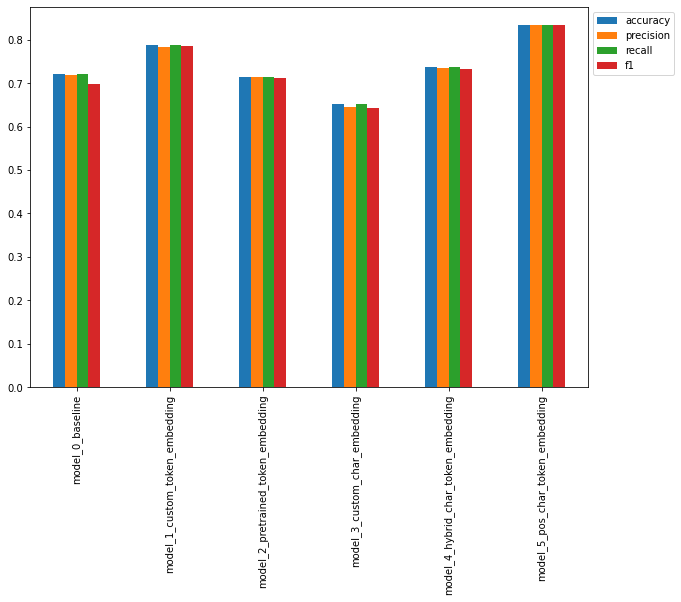

In [245]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

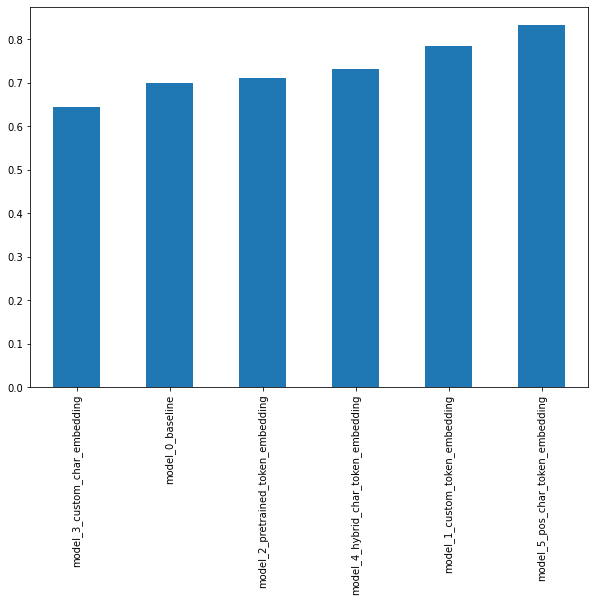

In [247]:
# Sort models results by f1-score

all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

### Save and load model

In [248]:
# Save the best performing model to SaveModel format(default)
model_5.save("skimlit_tribrid_model")


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [250]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")


In [251]:
# Make predictions with loaded_model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [252]:
# Calculate results of loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded, 
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.38739573679332,
 'f1': 0.8328280846183697,
 'precision': 0.8326422542471428,
 'recall': 0.8338739573679332}

In [253]:
model_5_results

{'accuracy': 83.38739573679332,
 'f1': 0.8328280846183697,
 'precision': 0.8326422542471428,
 'recall': 0.8338739573679332}

In [257]:
 assert model_5_results == loaded_model_results

In [258]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

## Download and load in a pretrained model from Google storage

In [259]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [260]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-08-14 19:33:17--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M  94.6MB/s    in 9.9s    

2021-08-14 19:33:28 (93.1 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  

In [261]:
# Load in downloaded Google storage model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model")


In [262]:
# Evaluate the loaded Google Storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)


945/945 [==============================] - 26s 25ms/step - loss: 0.9459 - accuracy: 0.8283


[0.9459028244018555, 0.8283132314682007]

## Your challenges

1. Turn the test data samples into a tf.data Dataset(fast loading) and then evaluate(make predictions) the best performing model on the test samples.

2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).

3. Make exaple predictions (on RCT abstracts from the wild), you can go to PubMed to find these :
https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
      * Some examples : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json

4. See the exercises and extra curriculum on GitHub to further test your skills (for section 09)
